In [1]:
import sys
sys.path.append("../")

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from src.datasets.imdb import load_imdb, word_to_idx
from src.utils.logger import get_logger
from src.utils.session import reset_session
from src.utils.plot import plot_history

2024-12-10 15:47:19.690880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
_ = get_logger()

## Config

In [4]:
# keep top-10000 frequent words
max_features = 10000

# fix document length
max_len = 500

# model path
base_model_dir = "../model"
os.makedirs(base_model_dir, exist_ok=True)

ckpt_path = os.path.join(base_model_dir, "cnn_sentiment", "ckpt")

## Read Data

In [5]:
(
    (X_train_raw, y_train_raw),
    (X_valid_raw, y_valid_raw),
    (X_test_raw, y_test_raw),
) = load_imdb(num_words=max_features, val_split=True)

[INFO] num train: 20000 (imdb.py:35)
[INFO] num valid: 5000 (imdb.py:36)
[INFO] num test: 25000 (imdb.py:37)


In [6]:
idx_to_word = {v: k for k, v in word_to_idx.items()}

In [7]:
np.random.seed(1234)
samp_idxs = np.random.choice(range(len(X_train_raw)), size=5)

for i in samp_idxs:
    x = X_train_raw[i]
    y = y_train_raw[i]

    review = " ".join([idx_to_word[n] for n in x])
    print(f"==> review: {i} (sentiment={y})")
    print(f"{review}\n")

==> review: 1318 (sentiment=0)
the out least that crack this of and and and you church out new part was moments scene in can don't that with hair to they for my that with supporting wanted is around mind business i i watch italian since was with independent in also some best off as not supposed 2006 in people her movie of pieces br of on with this of expression i i was off his just they an of horses he mrs to michael humour of films he and been of horses director michael surprising to of sure to sure brings br and to and 1970's are of on throughout of enough for was example seven in through in of on to notorious except was these one in at and who of watched being and are of lessons to and disabled dates she an of my are about sentenced try it's funny being our is campbell it's witness about solid out in one and and philosophical dom are of goes an br as story at heroin what of little films defies last with very not with do had do is then does don't in people recommend this of myself i 

In [8]:
# number of distinct words in train / test dataset

s1 = set()
s2 = set()

for x in X_train_raw:
    s1.update(x)

for x in X_valid_raw:
    s1.update(x)

for x in X_test_raw:
    s2.update(x)

print(f"Train num_words/min_index/max_index: {len(s1)}/{min(s1)}/{max(s1)}")
print(f"Test num_words/min_index/max_index: {len(s2)}/{min(s2)}/{max(s2)}")

Train num_words/min_index/max_index: 9998/1/9999
Test num_words/min_index/max_index: 9951/1/9999


## Preprocess

Text(0, 0.5, 'Frequency')

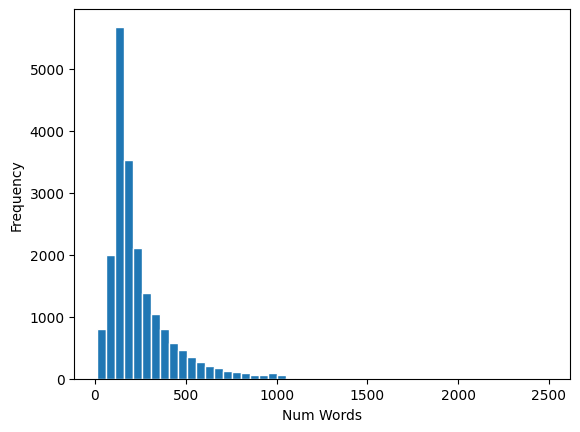

In [9]:
num_train_words = list(map(len, X_train_raw))

fig, ax = plt.subplots(1, 1)
ax.hist(num_train_words, bins=50, edgecolor="white")
ax.set_xlabel("Num Words")
ax.set_ylabel("Frequency")

In [10]:
X_train = sequence.pad_sequences(X_train_raw, maxlen=max_len)
X_valid = sequence.pad_sequences(X_valid_raw, maxlen=max_len)
X_test = sequence.pad_sequences(X_test_raw, maxlen=max_len)

In [11]:
X_train.shape, X_valid.shape, X_test.shape

((20000, 500), (5000, 500), (25000, 500))

In [12]:
y_train = to_categorical(y_train_raw)
y_valid = to_categorical(y_valid_raw)
y_test = to_categorical(y_test_raw)

In [13]:
y_train.shape, y_valid.shape, y_test.shape

((20000, 2), (5000, 2), (25000, 2))

## Train Mode

In [14]:
def build_model(
    input_dim: int,
    input_length: int,
    embedding_dim: int = 128,    
) -> Model:
    inputs = layers.Input(shape=(input_length,))
    x = layers.Embedding(input_dim=input_dim, output_dim=embedding_dim, input_length=input_length)(inputs)
    x = layers.Conv1D(filters=32, kernel_size=7, strides=1, activation="relu")(x)
    x = layers.MaxPool1D(pool_size=5)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(2, activation="softmax")(x)
    model = Model(inputs, outputs)
    return model

In [15]:
model = build_model(input_dim=max_features, input_length=max_len)

2024-12-10 15:47:25.335195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-10 15:47:25.338114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-10 15:47:25.338300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-10 15:47:25.338937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 32)                100384    
                                                             

In [17]:
model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [18]:
es_cb = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
ckpt_cb = ModelCheckpoint(
    filepath=ckpt_path,
    monitor="val_loss",
    mode="min",
    save_weights_only=True,
    save_best_only=True
)

In [19]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=256,
    callbacks=[es_cb, ckpt_cb]
)

Epoch 1/50


2024-12-10 15:47:26.732103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-12-10 15:47:27.788845: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6234010960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-10 15:47:27.788874: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-12-10 15:47:27.792226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-10 15:47:27.885780: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 [==============================] - 12s 116ms/step - loss: 0.6421 - accuracy: 0.6169 - val_loss: 0.3796 - val_accuracy: 0.8422
Epoch 2/50
79/79 [==============================] - 8s 95ms/step - loss: 0.2810 - accuracy: 0.8870 - val_loss: 0.2616 - val_accuracy: 0.8972
Epoch 3/50
79/79 [==============================] - 6s 78ms/step - loss: 0.1614 - accuracy: 0.9414 - val_loss: 0.2819 - val_accuracy: 0.8938
Epoch 4/50
79/79 [==============================] - 5s 64ms/step - loss: 0.1019 - accuracy: 0.9666 - val_loss: 0.3499 - val_accuracy: 0.8810
Epoch 5/50
79/79 [==============================] - 5s 65ms/step - loss: 0.0593 - accuracy: 0.9847 - val_loss: 0.4133 - val_accuracy: 0.8772
Epoch 6/50
79/79 [==============================] - 5s 59ms/step - loss: 0.0313 - accuracy: 0.9933 - val_loss: 0.4989 - val_accuracy: 0.8762
Epoch 7/50
79/79 [==============================] - 4s 46ms/step - loss: 0.0159 - accuracy: 0.9973 - val_loss: 0.5612 - val_accuracy: 0.8738
Epoch 7: early stoppin

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Epoch', ylabel='Cross-Entropy'>)

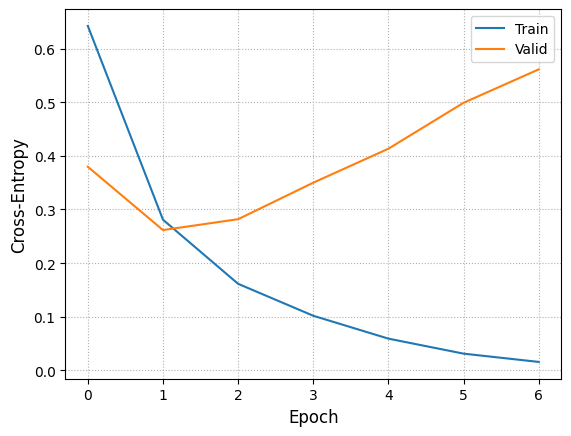

In [20]:
plot_history(history, ylabel="Cross-Entropy")

In [21]:
# load best model

model.load_weights(ckpt_path)

In [22]:
# train loss / accuracy

model.evaluate(X_train, y_train)

625/625 [==============================] - 4s 7ms/step - loss: 0.1626 - accuracy: 0.9480


[0.1626109480857849, 0.9480000138282776]

In [23]:
# valid loss / accuracy

model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 5ms/step - loss: 0.2616 - accuracy: 0.8972


[0.26163557171821594, 0.8971999883651733]

In [24]:
# test loss / accuracy

model.evaluate(X_test, y_test)

782/782 [==============================] - 5s 7ms/step - loss: 0.2920 - accuracy: 0.8762


[0.29204949736595154, 0.8762400150299072]